In [1]:
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
xgb.set_config(verbosity=2)

In [ ]:
'''
    Result summary:
    Train on seninel (1)_2 dataset - xgb - >95% - easily overfit  - but heavly underfit with cloud_shadow dataset
    Probaly bad labeling valid test - river as shadow
    Try on clip_1 to 3 dataset

'''

In [ ]:
# input_dir = r"./raw_final/xgdata"
# for mask_path in glob(os.path.join(input_dir,"*_label.tif")):
#     im_path = mask_path.replace("_label","")
#     with rasterio.open(mask_path) as msk:
#         with rasterio.open(im_path) as src:
#             data = src.read()
#             mask = msk.read()

In [2]:
with rasterio.open(r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/sentinel_1 (2)_label.tif") as msk:
    with rasterio.open(r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/sentinel_1 (2).tif") as src:
        data = src.read()
        mask = msk.read()
    src.close()
msk.close()

In [3]:
from rasterio.plot import reshape_as_image
# data = reshape_as_image(data)
mask = mask.squeeze(0)

In [39]:
# features importance visualization
# corr_mat = mydata.corr()
# sns.heatmap(corr_mat, annot=True)
# plt.show()

In [4]:
feature = data.reshape(4,-1).swapaxes(0,1)
label = (mask-1).flatten()

In [5]:
from sklearn.model_selection import train_test_split

num_samples = 10000000
X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.1, random_state=123)

# dtrain = xgb.DMatrix(data = X_train, label = y_train)
# dval = xgb.DMatrix(data = X_val, label = y_val)

In [6]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y = y_train #provide your own target name
)


In [7]:
# weight_scale = (label==0).sum()/((label==1).sum()+ (label==2).sum())

xg_class = xgb.XGBClassifier(objective = "multi:softmax",
    max_depth = 6, n_estimators = 1000, learning_rate= 0.03,
    min_child_weight= 1, colsample_bytree= 0.8,
    scale_pos_weight= 1, gpu_id =0, tree_method= 'gpu_hist', silent = False,
    verbosity = 2, random_state = 24
)

# xg_class = xgb.XGBClassifier(
#                             max_depth = 3, n_estimators = 10,
#                             gpu_id =0, tree_method= 'gpu_hist'
# )

In [8]:
xg_class.fit(X_train, y_train, sample_weight=sample_weights)

[10:01:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:627: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=24, reg_alpha=0, ...)

In [10]:
save_path = r"./saved_weight_xg/XG_weight.json"
xg_class.save_model(save_path)

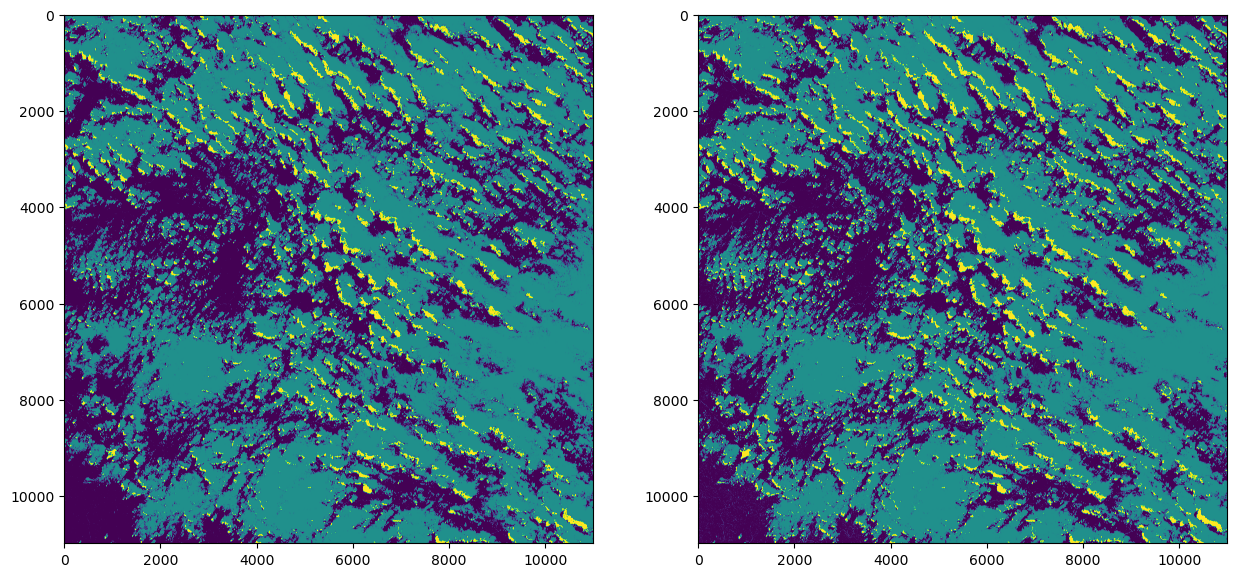

In [164]:
new_mask = y_pred.reshape(10980, 10980)

plt.figure(figsize=(15,15), dpi=100)
plt.subplot(1,2,1)
plt.imshow((label*100).reshape(10980, 10980))

plt.subplot(1,2,2)
plt.imshow(new_mask)

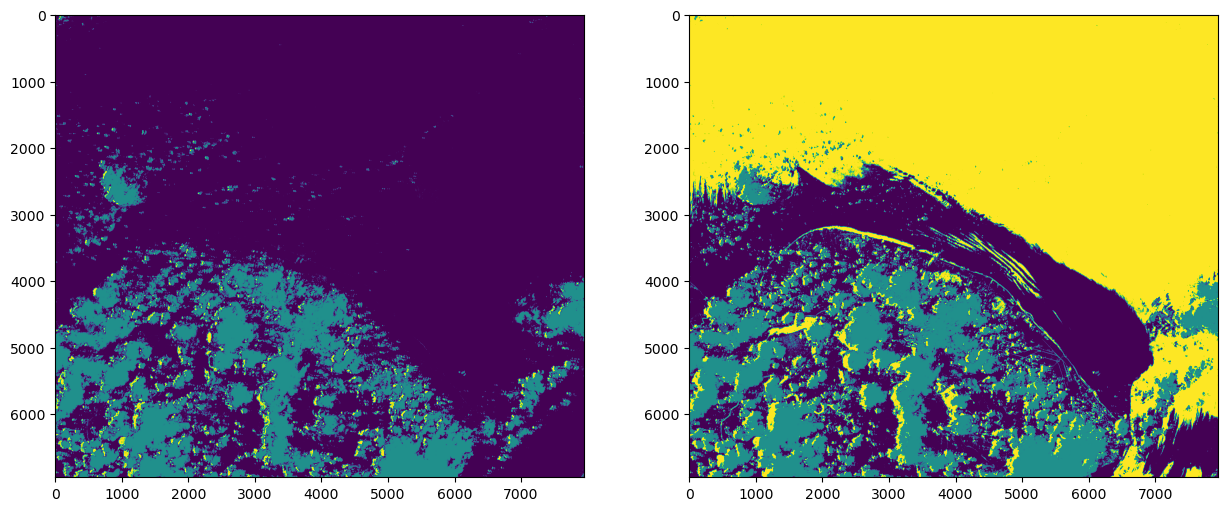

In [172]:
new_mask2 = y_pred2.reshape(6948, 7941)

plt.figure(figsize=(15,15), dpi=100)
plt.subplot(1,2,1)
plt.imshow((label2*100).reshape(6948, 7941))

plt.subplot(1,2,2)
plt.imshow(new_mask2)

In [33]:
## Write mask
save_mask = r"./raw_final/xgdata/cloud shadow_2_predict.tif"
out_meta = msk2.meta
with rasterio.open(save_mask, "w", compress='lzw', **out_meta) as dest:
    dest.write((new_mask2[...,np.newaxis]+1).swapaxes(0,2).swapaxes(1,2))

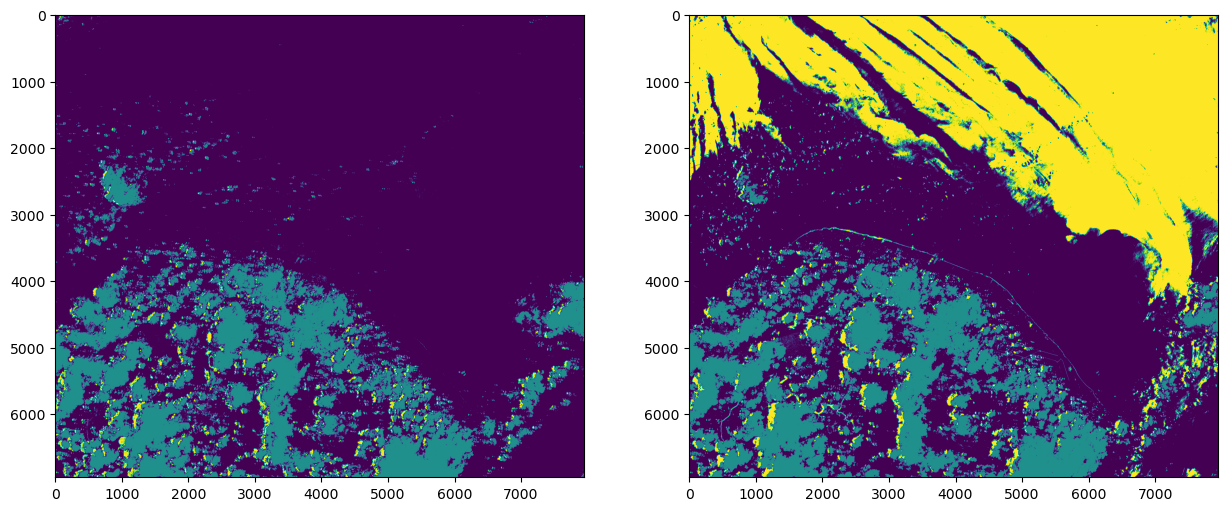

In [15]:
new_mask2 = y_pred2.reshape(6948, 7941)

plt.figure(figsize=(15,15), dpi=100)
plt.subplot(1,2,1)
plt.imshow((label2*100).reshape(6948, 7941))

plt.subplot(1,2,2)
plt.imshow(new_mask2)

In [11]:
im_path2 = r"./raw_final/cloud shadow_2.tif"
mask_path2 = r"./raw_final/cloud shadow_2_label.tif"
with rasterio.open(mask_path2) as msk2:
    with rasterio.open(im_path2) as src2:
        data2 = src2.read()
        mask2 = msk2.read()
mask2 = mask2.squeeze(0)

In [12]:
from sklearn.metrics import jaccard_score, f1_score

feature2 = data2.reshape(4,-1).swapaxes(0,1)
label2 = (mask2-1).flatten()
y_pred2 = xg_class.predict(feature2)

jaccard_score(label2, y_pred2, average='weighted')

0.600671352761281

In [13]:
f1_score(label2, y_pred2, average='weighted')

0.741441267135486

In [26]:
from sklearn.metrics import jaccard_score, f1_score

y_pred = xg_class.predict(X_val)
# predictions = [round(value) for value in y_pred]
predictions = np.around(y_pred,2)
jaccard_score(y_val, predictions, average='weighted')

0.9411404872826877

In [137]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions, average='weighted', )

0.9745065354424011

In [145]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, predictions, average='weighted')

0.9513307495698148